# Example: North-to-south strip of Spiekeroog 
## Implementation of the phase-averaged tidal boundary condition (PA-TBC) in MODFLOW-2005 using flopy

Here, the implementation of the phase-averaged tidal boundary condition (PA-TBC) presented in **Haehnel et al. (202X)** is showcased for a small strip of the island of Spiekeroog, Northern Germany.

Input data is in 'data/'
* allow_tbc.tif, model cells allowed to hold a PA-TBC
* spk_part_dem.tif, digital elevation model for the model area (Sievers et al. 2020)
* tide_WW_avg30mins_2012-11-01_to2014-11-30.txt, 30-min averaged sea level data of tide gauge Wangerooge West (WSV, 2021)
* tide_WW_phaseavg_2012-11-01_to2014-11-30.txt, high and low water, mean tide level (based on WSV, 2021)

Model input and output files are saved in folder 'mf2005_spk_part_pa-tbc' (~1.8 GB).
QGIS file 'define_tbc_allow_area.qgz' is for definition of the areas allowed to hold the PA-TBC (below 4 m asl and not within the dune area of the island).

### References
**Haehnel et al. (202X)**

Röper, T., Kröger, K. F., Meyer, H., Sültenfuss, J., Greskowiak, J., & Massmann, G. (2012). Groundwater ages, recharge conditions and hydrochemical evolution of a barrier island freshwater lens (Spiekeroog, Northern Germany). Journal of Hydrology, 454–455, 173–186. https://doi.org/10.1016/j.jhydrol.2012.06.011

Sievers, J., Rubel, M., & Milbrandt, P. (2020). EasyGSH-DB: Bathymetrie (1996-2016) [Data set]. Bundesanstalt für Wasserbau (BAW) [Federal Waterways Engineering and Research Institute]. https://doi.org/10.48437/02.2020.K2.7000.0002

Wasserstraßen- und Schifffahrtsverwaltung des Bundes (WSV) [Federal Waterways and Shipping Administration]. (2021). Sea level time series data for tide gauge Wangerooge West from 1999 to 2021 (1 min) [Data set]. Provided by Bundesanstalt für Gewässerkunde (BfG) [German Federal Institute of Hydrology].

### License
The digital elevation model data is from the EasyGSH-DB project (https://mdi-de.baw.de/easygsh/)
The data is licensed under a
Creative Commons Attribution 4.0 International License
(CC BY 4.0)
https://creativecommons.org/licenses/by/4.0/

License information is provided under
https://mdi-de.baw.de/easygsh/EasyEN_Imp_Daten.html#home
and https://datenrepository.baw.de/trefferanzeige?cmd=doShowDocument&docuuid=590135db-1776-450d-9fe3-ac6484cf64aa&plugid=/ingrid-group:iplug-ige-datenrepo


The tide data obtained from the WSV is licensed under a
Creative Commons Attribution 4.0 International License
(CC BY 4.0)
https://creativecommons.org/licenses/by/4.0/

License information is provided under
https://www.govdata.de/web/guest/suchen/-/details/pegelonline (German language only)

The tide data included here is processed from the original 1-min time series received from the WSV.


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import flopy
import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
from matplotlib import cm
from matplotlib import patches
from matplotlib import lines

path_patbc = os.path.abspath('../../')
sys.path.append(path_patbc)
import mfpatbc

In [2]:
#plt.switch_backend('nbAgg')
%matplotlib inline

### Tide gauge data

Sea level data is from tide gauge Wangerooge West. Measurement intervall is 1 min. This data was kernel smoothed. Data was averaged to 30 minute intervalls. High water (HW) and low water (LW) data was obtained from the kernel smoothed 1 minute increment time series. Mean tide level
$$\mathrm{MTL} = \frac{\mathrm{HW}+\mathrm{LW}}{2}$$

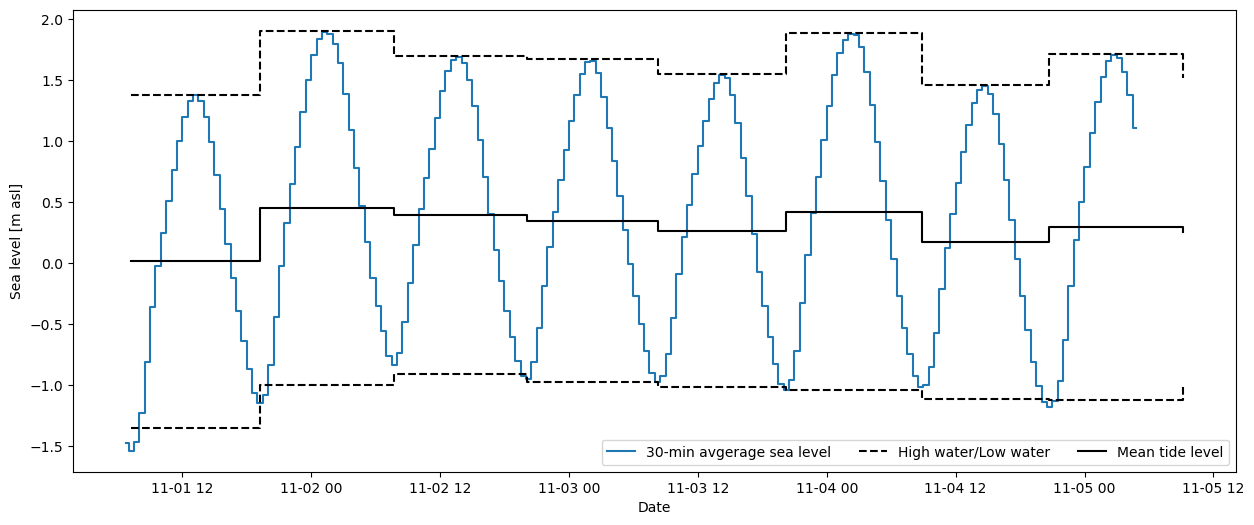

In [3]:
# Import tide gauge data -----
# Define time period
start_time = datetime.datetime(2012, 11, 1, 1, 00, 00)
end_time = datetime.datetime(2014, 11, 30, 23, 59, 59)

# 30-min averaged sea level data
tide = pd.read_csv('data/tide_WW_avg30mins_2012-11-01_to_2014-11-30.txt',
                  parse_dates = ['DateTime_Start', 'DateTime_Mean', 'DateTime_End'])
tide = tide.loc[(tide.DateTime_Start >= start_time) & \
                (tide.DateTime_End <= end_time), ]

# Phase-averaged data, High and low water information
hwlw = pd.read_csv('data/tide_WW_phaseavg_2012-11-01_to_2014-11-30.txt',
                  parse_dates = ['DateTime_Start', 'DateTime_Mean', 'DateTime_End'])
mhw = hwlw.HW.mean()
mlw = hwlw.LW.mean()
hwlw = hwlw.loc[(hwlw.DateTime_Start >= start_time) & \
                (hwlw.DateTime_End <= end_time), ]


# Visualize -----
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.step(tide.DateTime_Mean.values[11:200], tide.WaterLevelNHN_Mean.values[11:200], where = 'mid',
       label = '30-min avgerage sea level')
ax.step(hwlw.DateTime_Start.values[0:9], hwlw.HW.values[0:9], where = 'post', linestyle = '--', color = 'k',
       label = 'High water/Low water')
ax.step(hwlw.DateTime_Start.values[0:9], hwlw.LW_Mean.values[0:9], where = 'post', linestyle = '--', color = 'k')
ax.step(hwlw.DateTime_Start.values[0:9], hwlw.SL_HWLW.values[0:9], where = 'post', linestyle = '-', color = 'k',
       label = 'Mean tide level')

ax.set_xlabel('Date')
ax.set_ylabel('Sea level [m asl]')

ax.legend(ncol = 3)

### Digital elevation model

Surface elevation data is required as input data for the PA-TBC and to define beach slopes for the PA-TBC. Figure below shows surface elevations and some locations (points) where simulation results are plotted for further below.

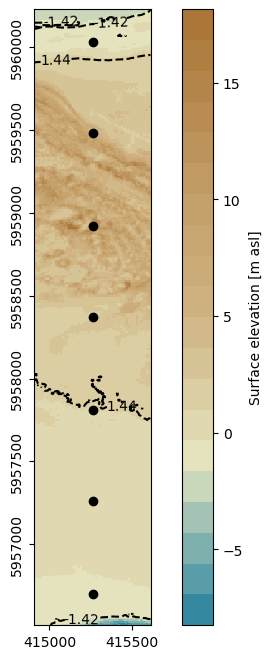

In [4]:
# Import surface elevation data -----
rst=rasterio.open('data/spk_part_dem.tif') ### topography on 10m x 10m grid
top=np.copy(rst.read()[0]) # get topography

# Discretization information
dx = dy = rst.get_transform()[1]
xul, yul = rst.get_transform()[0], rst.get_transform()[3]
nrow = top.shape[0] # number of model rows
ncol = top.shape[1] # number of model columns

# Cell center locations
x = xul + np.arange(0, dx*ncol, dx) + 0.5*dx
y = (yul - np.arange(0, dy*nrow, dy) - 0.5*dy)
X, Y = np.meshgrid(x, y)

# Locations where simulation results are plotted
row_plt = np.linspace(20, nrow-20, 7).astype(int)
col_plt = int(ncol/2)


# Visualize topography -----
# Topography colorbar
clrs_topo = np.array([(52, 138, 162), (230, 230, 193),
                      (209, 181, 131), (192, 153, 97), (171, 119, 57)])/256
cmap_topo = colors.LinearSegmentedColormap.from_list('cmap_topo', clrs_topo, N = 20)

# Plot
fig, ax = plt.subplots(1, figsize=(8, 8))
im = ax.pcolormesh(X, Y, top, shading = 'nearest', cmap = cmap_topo)
cbar = fig.colorbar(im, ax = ax)
cbar.set_label('Surface elevation [m asl]')

ct = ax.contour(X, Y, top, levels = [mlw, mhw], colors = 'k', linestyles = '--')
ax.clabel(ct, fmt = '%.2f', inline_spacing = 50)

ax.plot(x[col_plt].repeat(row_plt.size), y[row_plt], 'ko')

yt = ax.get_yticks()[1:-1:]
ax.set_yticks(yt)
ax.set_yticklabels([int(ytl) for ytl in yt], rotation = 90, verticalalignment = 'center')

ax.set_aspect('equal')

### Model set-up

Set-up same as in **Haehnel et al. (202X)**. Uppermoste layer bottom elevation set such, that it never falls dry during simulation.

Recharge is set to 350 mm/yr, a value realistic for Spiekeroog (Röper et al., 2012).

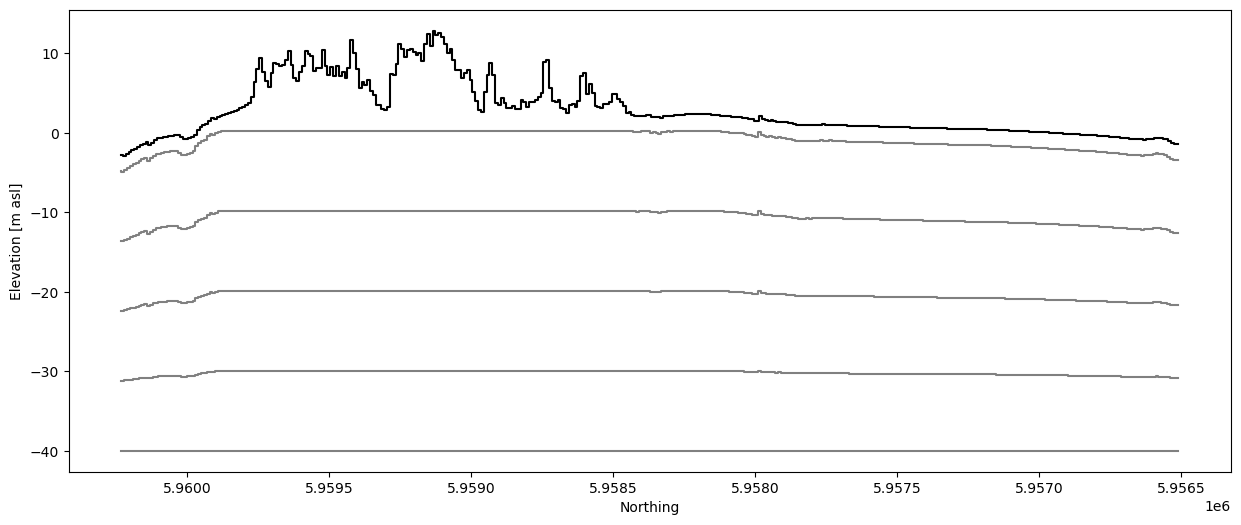

In [5]:
# Vertical discretization ----
nlay = 5

# Here we make the bottoms for each layer
# We want to make the bottom of each cell in the first layer sufficently low that the cell does not become dry
botm = np.zeros((nlay,nrow,ncol))
botm[0,:,:] = top-2.0
botm[botm>0.2] = 0.2 # make that the bottom of the top layer is always sufficiently low
botm[-1,:,:] = -40 ## bottem of last layer: base of the aquifer at -40m 

# make equidistant bottoms for the other layers
for j in range(nrow):
    for k in range(ncol):
        botm[1:-1,j,k] = np.linspace(botm[0,j,k], botm[-1,j,k], nlay)[1:-1]

# get cell thicknesses     
dz = np.zeros((nlay,nrow,ncol))
dz[0] = top-botm[0,:,:]
dz[1:nlay] = -np.diff(botm,axis=0)

# Visualize discretization -----
idx = 10
fig, ax = plt.subplots(1, 1, num = 0, figsize = (15, 6))
ax.step(y, top[::, idx], where = 'mid', color = 'k')
for k in range(nlay):
    ax.step(y, botm[k, ::, idx], color = 'grey')
    
ax.set_xlabel('Northing')
ax.set_ylabel('Elevation [m asl]')
    
ax.invert_xaxis()

In [6]:
# Create MODFLOW model object -----
path = '.'
mf2005_exe = os.path.abspath('../../bin/mf2005')
modelname = 'mf2005_spk_part'
model_ws = os.path.join(path, modelname)
m = flopy.modflow.Modflow(modelname = modelname, exe_name = mf2005_exe, model_ws = model_ws)

# Define parameters ----
hk = 2e-4 * 86400 # m/day
sy = 0.3
vka = 1
vk = hk/vka
z_D = np.unique(botm[-1].copy())[0]

ss = 1e-5

In [7]:
# Create objects for MODFLOW packages -----

# Discretization
# Stress period length is period length of tidal cycles
years_per0 = 20
perlen = (hwlw.DateTime_End.values - hwlw.DateTime_Start.values).astype('timedelta64[s]') # sec
perlen = np.concatenate([[365*years_per0], perlen.astype('float') / 86400], axis = 0) # days

nper = perlen.size
nstp = np.concatenate([[1], np.repeat(3, nper-1)], axis = 0)

dis = flopy.modflow.ModflowDis(
    m,
    nlay = nlay,
    nrow = nrow,
    ncol = ncol,
    delr = dx,
    delc = dy,
    top = top, 
    botm = botm, 
    perlen = perlen, 
    nstp = nstp, 
    nper = nper,
    steady=False,
    itmuni = 4,
    lenuni = 2,
    xul = xul,
    yul = yul
)

# Basic
# Set initial heads to HW of first tidal cycle
h0 = hwlw.HW.values[0]
ibound = np.ones((nlay,nrow,ncol))

bas = flopy.modflow.ModflowBas(
    m,
    ibound = ibound,
    strt = h0
)


# Layer Property Flow
laytype = np.full(dis.nlay, 0)
laytype[0] = 1

lpf = flopy.modflow.ModflowLpf(
    m,
    laytyp = laytype,
    chani = 1,
    layvka = 0,
    laywet = 0,
    hk = hk,
    vka = vk,
    ss = ss,
    sy = sy,
    ipakcb=0
)


# Recharge
rch = flopy.modflow.ModflowRch(
    m,
    rech = 350 / (1e3*365) # m/d
)


# Preconditioned Conjugate-Gradient
pcg = flopy.modflow.ModflowPcg(
    m, 
    mxiter=50, 
    iter1=30, 
    hclose=1e-5, 
    rclose=1
)


# Ouput control
# Define stress period data
opts = ['save head 1']
spd_oc = {}
for k in np.arange(nper):
    spd_oc[(k, nstp[k]-1)] = opts

oc = flopy.modflow.ModflowOc(
    m,
    stress_period_data = spd_oc
)

### Phase-averaged tidal boundary condition

Each stress period resembles a tidal cycle from low water to low water. Thus, stress period lengths vary.
Input data for the PA-TBC for each stress period:
* flopy model object (m)
* phase-averaged sea level $\overline{h}_s$
* tidal amplitude $A=\mathrm{HW}-\overline{h}_s$
* period length of the tidal cycle from low water to low water $T$
* horizontal hydraulic conductivity *K_h* (hk)
* vertical anisotropy factor $v_K=K_h/K_v$ (vka)
* specific yield $S_y$ (sy)
* depth of the aquifer base (relative to datum, e.g. m asl) $z_D$ (used to calculate saturated aquifer thickness $D = \overline{h}_s-z_D$)
* beach slopes $\beta$ as gradients ($\tan(\beta)$)
* cells allowed to hold a PA-TBC (allow)

Beach slopes can either be provided for each cell with its local value (cma = 'CELLBS') or as the median of all cells between the mean high and mean low water line (cma = 'CONSTBS'). The latter is favourable for sandy, well permeable sediments (**Haehnel et al. (202X)**).

Defining a bool array for areas to be excluded from the setup of PA-TBC is not required but can save a considerable amount of storage for input files. For this simulation it also helps to make simulation results more realistic, since the dune area is excluded from the PA-TBC. This area is beyond the reach of the direct tidal influence and water should be able to stand above ground surface without drainage there.


In [8]:
# Phase-averaged tidal boundary condition -----

# Define coastal morphology approach
cma = 'CONSTBS'

# Tidal information
# Phase-averaged sea level as mean tide level (MTL)
hs = 0.5 * (hwlw.HW.values + hwlw.LW_Mean.values)
hs = np.concatenate([[hs.mean()], hs], axis = 0)
# Tidal amplitude
A = np.concatenate([[hwlw.HW.values.mean() - hs.mean()], hwlw.HW.values - hs[1::]], axis = 0) # meter
# Period length
T = np.concatenate([[perlen[1::].mean()], perlen[1::]], axis = 0) # day

# Calculate beach slopes as gradient
grad = np.gradient(dis.top.array, dx, dy)
slope = np.sqrt(grad[0]**2 + grad[1]**2)
beta = np.arctan(slope)*180/np.pi # deg

if cma == 'CONSTBS':
    is_intt = (dis.top.array >= mlw) & (dis.top.array <= mhw) & (ibound[0] == 1)
    slope_use = np.median(slope[is_intt])
    print('Median beach slope: ' + '{:.3f}'.format(np.arctan(slope_use)*180/np.pi) + '°')
if cma == 'CELLBS':
    slope_use = slope
    
# Define areas allowed to hold PA-TBC
# Surface elevation below 4 m asl and seaward of dune area
rst = rasterio.open('data/allow_tbc.tif') ### topography on 10m x 10m grid
allow_tbc = np.copy(rst.read()[0]).astype(bool) # get topography


Median beach slope: 0.144°


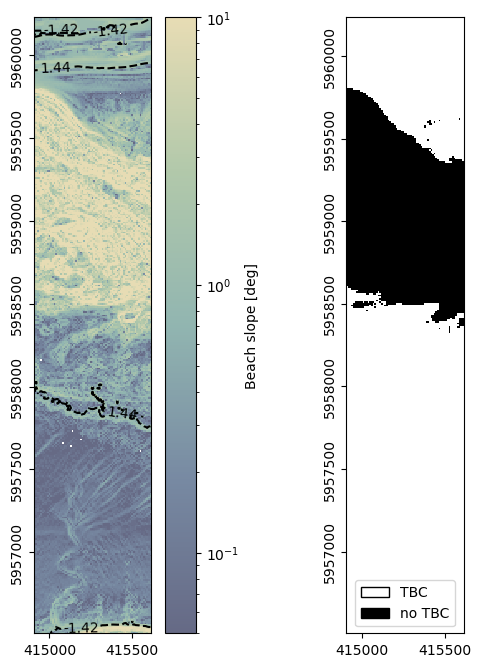

In [9]:
# Visualize slopes and TBC area
clrs_beta = np.array([(102, 106, 134), (120, 138, 163), (146, 182, 177),
                     (178, 201, 171), (232, 221, 181)])/256
cmap_beta = colors.LinearSegmentedColormap.from_list('cmap_beta', clrs_beta, N = 256)

fig, (axa, axb) = plt.subplots(1, 2, figsize=(8, 8))

# Beach slopes
im = axa.pcolormesh(X, Y, beta, cmap = cmap_beta, shading = 'nearest',
                   norm = colors.LogNorm(vmin = 0.05, vmax = 10))
cbar = fig.colorbar(im, ax = axa)
cbar.set_label('Beach slope [deg]')

ct = axa.contour(X, Y, top, levels = [mlw, mhw], colors = 'k', linestyles = '--')
axa.clabel(ct, fmt = '%.2f', inline_spacing = 20)

yt = axa.get_yticks()[1:-1:]
axa.set_yticks(yt)
axa.set_yticklabels([int(ytl) for ytl in yt], rotation = 90, verticalalignment = 'center')

axa.set_aspect('equal')

# TBC areas
axb.pcolormesh(X, Y, allow_tbc, shading = 'nearest', cmap = 'Greys_r')

yt = axb.get_yticks()[1:-1:]
axb.set_yticks(yt)
axb.set_yticklabels([int(ytl) for ytl in yt], rotation = 90, verticalalignment = 'center')

axb.set_aspect('equal')

handles = [patches.Patch(facecolor = 'white', edgecolor = 'k'),
          patches.Patch(facecolor = 'k', edgecolor = 'k')]
axb.legend(handles, ['TBC', 'no TBC'], loc = 'lower center')

There is an option to write the input files for GHB and DRN using a Fortran based approach which is faster than the flopy internal file write. This is especially handy for models with many cells that hold a PA-TBC and a lot of stress periods.

In [11]:
do_write_fort = False

# Set up PA-TBC object, loop through stress periods
spd_ghb = {}
spd_drn = {}
zep = []
for k, (mtl, amp, period) in enumerate(zip(hs, A, T)):
    # Create PA-TBC object for current stress period
    patbc = mfpatbc.PATBC(m, mtl, amp, period, hk, vka, sy, z_D, slope_use, 
                          allow = allow_tbc)

    # Get stress period entries for GHB input file
    spd_ghb[k] = patbc.get_ghb_stress_period_data()

    # Get stress period entries for DRN input file
    spd_drn[k] = patbc.get_drn_stress_period_data()

# Definition of GHB and DRN stress period data and flopy packages for Fortran based input file writing
if do_write_fort:
    # Only write dummy flopy objects, so that packages are written to nam-file
    ghb = flopy.modflow.ModflowGhb(m, stress_period_data = {0: [0, 0, 0, 0, 0]})
    drn = flopy.modflow.ModflowDrn(m, stress_period_data = {0: [0, 0, 0, 0, 0]})
    
# Normal, flopy based definition of GHB and DRN
else:
    # Using NOPRINT option to omit printing boundary condition information to list file
    ghb = flopy.modflow.ModflowGhb(
        m,
        stress_period_data = spd_ghb,
        options = ['NOPRINT']
    )

    drn = flopy.modflow.ModflowDrn(
        m,
        stress_period_data = spd_drn,
        options = ['NOPRINT']
    )

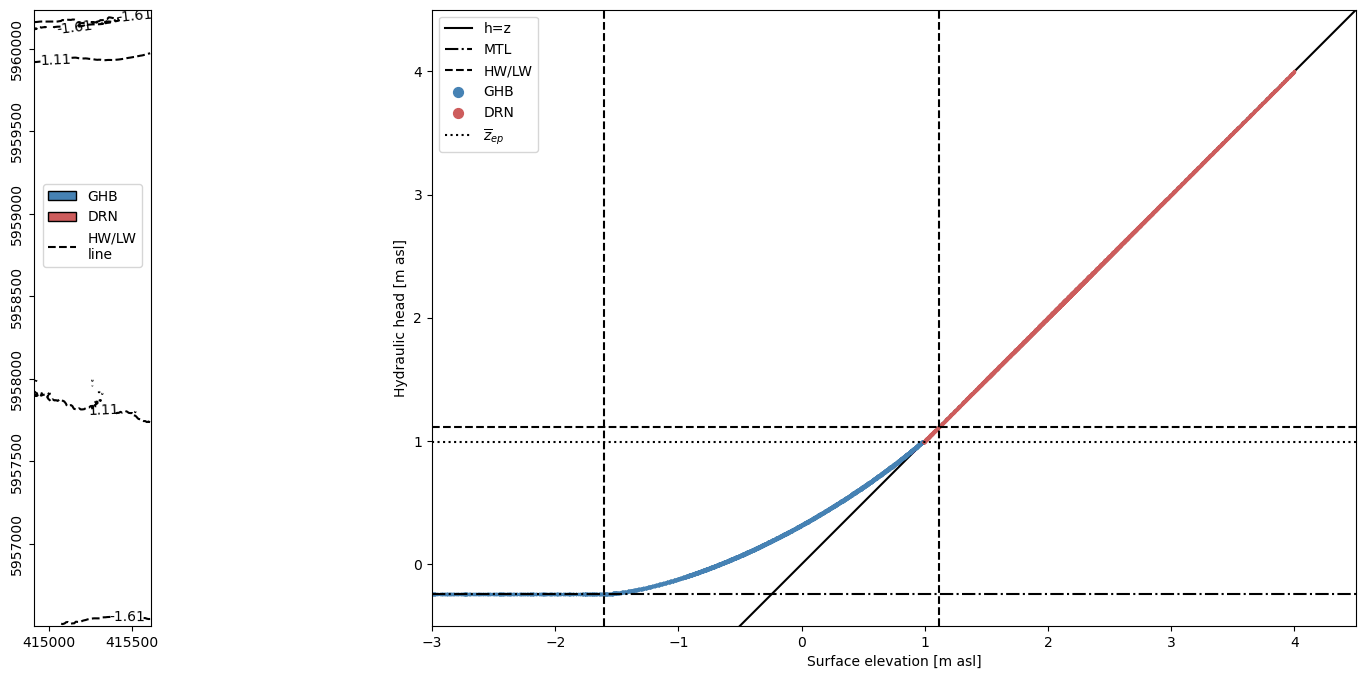

In [12]:
# Visualize example PA-TBC
fig = plt.figure(10, figsize = (20, 8))
gs = GridSpec(1, 5)
kper = 1467

ghbdata = np.array(spd_ghb[kper].tolist())
drndata = np.array(spd_drn[kper].tolist())

# Location of PA-TBC types
ax = fig.add_subplot(gs[0, 0])
p = flopy.plot.PlotMapView(m, ax = ax, modelgrid = m.modelgrid)
p.plot_bc('GHB', color = 'steelblue', kper = kper, zorder = 0)
p.plot_bc('DRN', color = 'indianred', kper = kper, zorder = 0)

ct = ax.contour(X, Y, top, levels = [hwlw.LW.values[kper-1], hwlw.HW.values[kper-1]], colors = 'k', linestyles = '--')
ax.clabel(ct, fmt = '%.2f', inline_spacing = 20)

yt = ax.get_yticks()[1:-1:]
ax.set_yticks(yt)
ax.set_yticklabels([int(ytl) for ytl in yt], rotation = 90, verticalalignment = 'center')

ax.set_aspect('equal')

handles = [patches.Patch(facecolor = 'steelblue', edgecolor = 'k'),
          patches.Patch(facecolor = 'indianred', edgecolor = 'k'),
          lines.Line2D([0], [0], color = 'k', linestyle = '--')]
ax.legend(handles, ['GHB', 'DRN', 'HW/LW\nline'], loc = 'center', bbox_to_anchor = (0.5, 0.65))


# PA-TBC hydraulic heads
ax = fig.add_subplot(gs[0, 1:])
ax.plot([-3, 4.5], [-3, 4.5], 'k', zorder = 0, label = 'h=z')

ax.hlines([hs[kper], hwlw.HW.values[kper-1]], xmin = -3, xmax = 4.5, linestyles = ['-.', '--'],
        colors = 'k', label = 'MTL')
ax.vlines([hwlw.LW_Mean.values[kper-1], hwlw.HW.values[kper-1]], 
         ymin = -0.5, ymax = 4.5, linestyles = '--', colors = 'k',
         label = 'HW/LW')

# GHB
row_ghb = ghbdata[::, 1].astype(int)
col_ghb = ghbdata[::, 2].astype(int)
h_ghb = ghbdata[::, 3]
z_ghb = patbc.z[row_ghb, col_ghb]

ax.scatter(z_ghb, h_ghb, s = 2, c = 'steelblue', label = 'GHB')

# DRN
row_drn = drndata[::, 1].astype(int)
col_drn = drndata[::, 2].astype(int)
h_drn = drndata[::, 3]
z_drn = patbc.z[row_drn, col_drn]

ax.scatter(z_drn, h_drn, s = 2, c = 'indianred', label = 'DRN')

# Predicted zep
if cma == 'CONSTBS':
    # For plotting purpose only
    lm = pd.read_csv('../../mfpatbc/coef_lm_sim-slopesteady_nwt.csv')
    zep = mfpatbc.predict_zep(hs[kper], A[kper], T[kper], hk, sy, hs[kper]-z_D, vka, slope_use, lm)

ax.hlines(zep, xmin = -3, xmax = 4.5, linestyles = ':', colors = 'k', label = '$\\overline{z}_{ep}$')

ax.set_xlim(-3, 4.5)
ax.set_ylim(-0.5, 4.5)

ax.set_xlabel('Surface elevation [m asl]')
ax.set_ylabel('Hydraulic head [m asl]')

ax.set_aspect('equal')

ax.legend(markerscale = 5)

Exemplary result of the PA-TBC for stress period 1466. GHB is used for all cells where $z > \overline{z}_{ep}$. The phase-averaged groundwater table exit point $\overline{z}_ {ep}$ is predicted by the empirical correction function of the PA-TBC. For $z \leq \overline{z}_{ep}$, DRN is used.

### Write input files and run simulation

In [14]:
# Write input files
if do_write_fort:
    packages = m.get_package_list()
    packages = [name for name in packages if (name != 'GHB') & (name != 'DRN')]
    
    m.write_input(SelPackList = packages)
    
    mfpatbc.write_ghb(m, spd_ghb, options = ['NOPRINT'])
    mfpatbc.write_drn(m, spd_drn, options = ['NOPRINT'])
    
else:
    m.write_input()

In [15]:
success, buff = m.run_model(silent=True)
if not success:
    raise Exception("MODFLOW did not terminate normally.")

### Visualize simulation results

It can be seen that the PA-TBC propagates the transient ocena dynamics with periods londer than semi-diurnal into the aquifer. Tidal overheight is produced and the ocean signal variability is attenuated with distance to coast. Well within the dune area only storm flood events have a direct impact.

Text(0, 0.5, 'Mean tide level [m asl]')

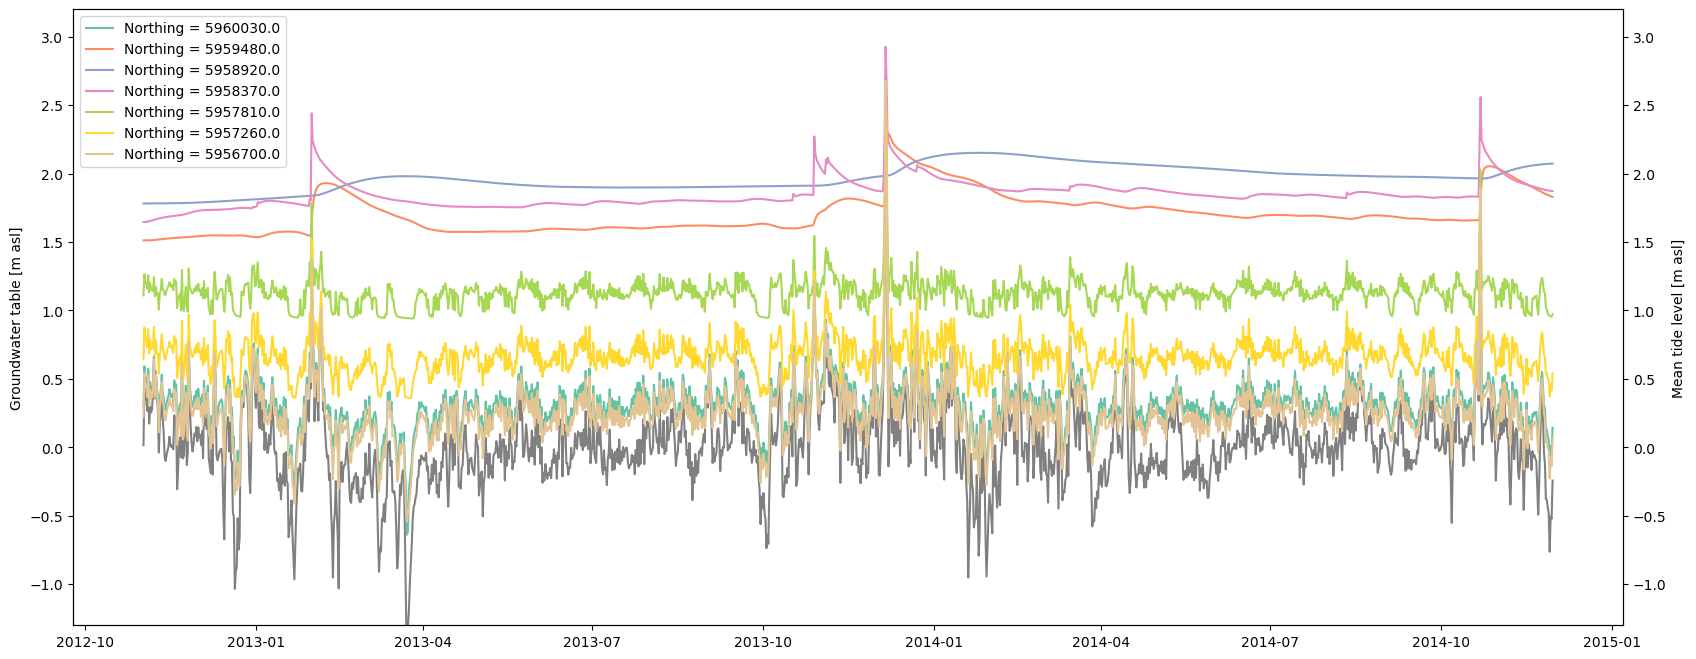

In [16]:
hdobj = flopy.utils.HeadFile(f'{model_ws}/{modelname}.hds')

hds = hdobj.get_alldata().squeeze()

clrs = cm.Set2(np.arange(0, row_plt.size))

fig, ax = plt.subplots(1, 1, num = 20, figsize = (20, 8))
for k, row in enumerate(row_plt):
    ax.plot(hwlw.DateTime_Mean.values, hds[1::, row, col_plt], color = clrs[k], label = f'Northing = {y[row]}')
ax.set_ylim(-1.3, 3.2)
ax.set_ylabel('Groundwater table [m asl]')
ax.set_zorder(10)
ax.patch.set_visible(False)
ax.legend()

axt = ax.twinx()
axt.plot(hwlw.DateTime_Mean.values, hwlw.SL_HWLW.values, color = 'grey', label = 'MTL')
axt.set_ylim(-1.3, 3.2)
axt.set_ylabel('Mean tide level [m asl]')
